In [80]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

# Load the dataset
df = pd.read_csv('health_trends_data.csv')  

# Convert date column to datetime 
df['date'] = pd.to_datetime(df['date'])
df.head()

,search_term,date,interest_score,year,month
0,intermittent fasting,2004-01-01,0,2004,1
1,intermittent fasting,2004-02-01,0,2004,2
2,intermittent fasting,2004-03-01,0,2004,3
3,intermittent fasting,2004-04-01,0,2004,4
4,intermittent fasting,2004-05-01,0,2004,5


We are going to look at the longevity of the trends to see if they are seasonal, yearly, etc. To do so, we got the months, the years, and we also shifted interest score back by 20 days. We chose 20 days arbitrarily after experiencing with a few other numbers. interest_score_diff is the difference in interest score between the actual score and the score 20 days prior - to shows a short-term pattern in trends interest.

In [81]:
# Extract month, year, and 20-day shift interest
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['interest_score_shift'] = df['interest_score'].shift(20)  
df['interest_score_diff'] = df['interest_score'].diff() 

# Drop NaN values cause by the shift
df.dropna(inplace=True)  
df

,search_term,date,interest_score,year,month,interest_score_shift,interest_score_diff
20,intermittent fasting,2005-09-01,0,2005,9,0.0,0.0
21,intermittent fasting,2005-10-01,0,2005,10,0.0,0.0
22,intermittent fasting,2005-11-01,0,2005,11,0.0,0.0
23,intermittent fasting,2005-12-01,0,2005,12,0.0,0.0
24,intermittent fasting,2006-01-01,0,2006,1,0.0,0.0
...,...,...,...,...,...,...,...
2995,sleep quality,2024-06-01,71,2024,6,63.0,-4.0
2996,sleep quality,2024-07-01,67,2024,7,57.0,-4.0
2997,sleep quality,2024-08-01,80,2024,8,56.0,13.0
2998,sleep quality,2024-09-01,87,2024,9,64.0,7.0


In [82]:
# Select features to investigate trend's longevity
features = ['interest_score_shift', 'interest_score_diff', 'month', 'year']

# Scale x features using standardization
for feature in features:
    mean = df[feature].mean()
    std_dev = df[feature].std()
    df[feature] = (df[feature] - mean) / std_dev

df[features].head()

,interest_score_shift,interest_score_diff,month,year
20,-1.413994,-0.004376,0.737338,-1.501612
21,-1.413994,-0.004376,1.028213,-1.501612
22,-1.413994,-0.004376,1.319088,-1.501612
23,-1.413994,-0.004376,1.609963,-1.501612
24,-1.413994,-0.004376,-1.589660,-1.334467


In [83]:
# Perform train test split
X = df[features]
y = df['interest_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state = 42)

In [84]:
# Run linear regression on train data
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Make predictions with test data
y_pred = lin_reg.predict(X_test)

# Calculate mse
residuals = y_test - y_pred  # Residuals
mse = np.mean(residuals ** 2)

# Calculate r^2
r2 = 1 - (mse)/(y_test.var()) 

# Evaluate Linear Regression
print(f"Linear Regression Mean Squared Error: {mse}")
print(f"Linear Regression R^2 value: {r2}")

Linear Regression Mean Squared Error: 202.6155902635384
Linear Regression R^2 value: 0.6674734263830786


In [85]:
# Fit the regression model on the full data set
lin_reg.fit(X, y)

# Make predictions and get residuals
y_preds = lin_reg.predict(X)
resids = y - y_preds

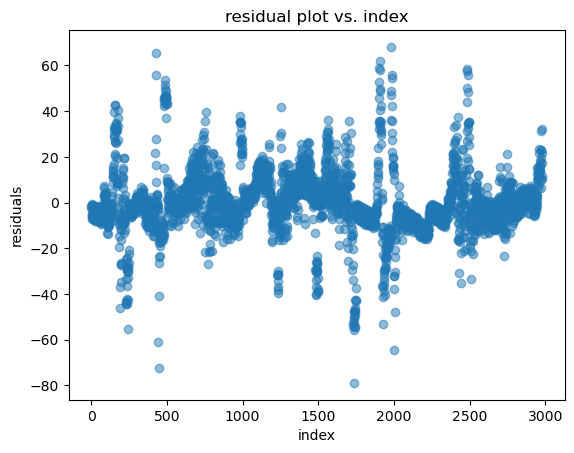

In [86]:
# Checking assumptions

# Plot index vs. residuals
plt.scatter(range(len(X)), resids, alpha=0.5)
plt.xlabel("index")
plt.ylabel("residuals")
plt.title("residual plot vs. index")
plt.show()

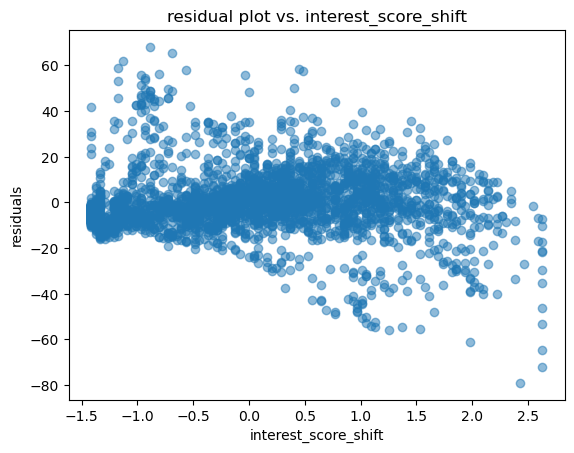

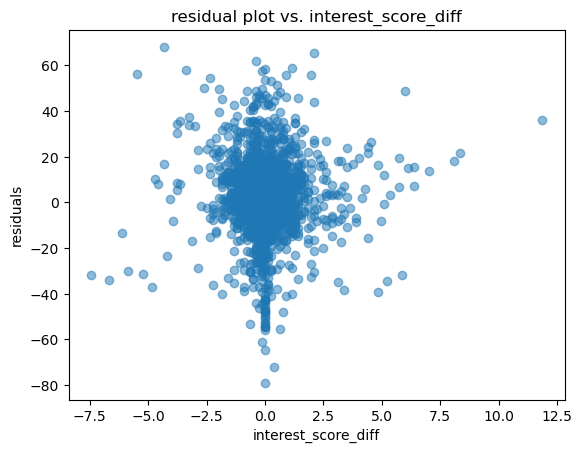

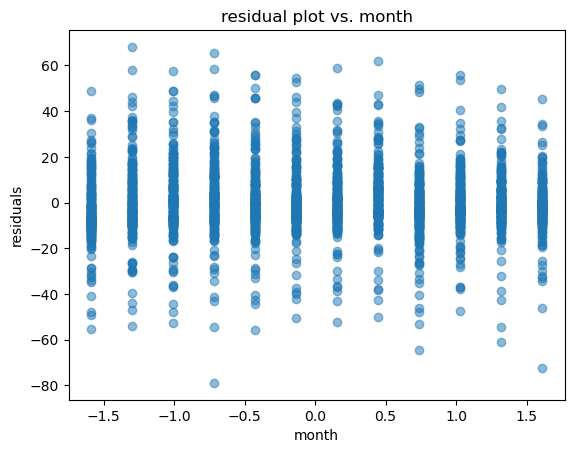

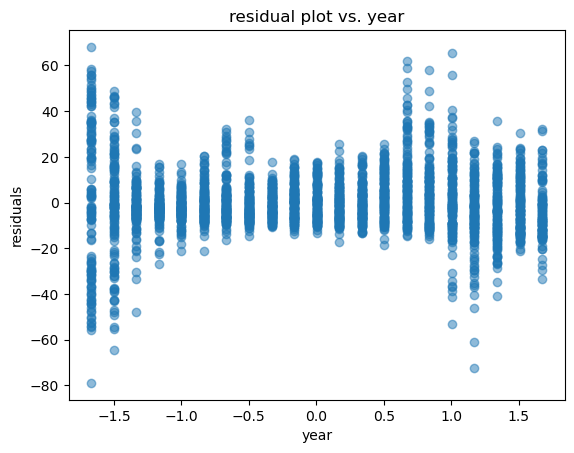

In [87]:
# Plot of feature vs. residuals
for feature in X.columns:
    plt.scatter(X[[feature]], resids, alpha=0.5)
    plt.xlabel(f"{feature}")
    plt.ylabel("residuals")
    plt.title(f"residual plot vs. {feature}")
    plt.show()

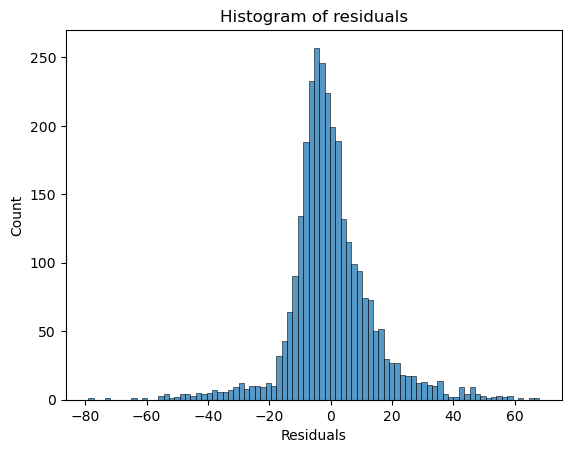

In [88]:
import seaborn as sns

# Plot histogram of residuals
sns.histplot(resids, kde = False)
plt.xlabel("Residuals")
plt.title("Histogram of residuals")
plt.show()

The R^2 value of 0.6674734263830786 in this case suggests that this multiple linear regression model has a moderately strong fit to the data. This means that the model, which takes into account both short and long time periods, explains a large portion of the variability in interest scores over time. The residuals vs. index plot spreads quite evenly across 0 with fluctuating pattern, suggesting that there is no autocorrelation between the features used in this model. However, there are possible outliers. For each of the residuals vs. x feature plots, the plots of residuals vs. interest score shift (short term) and months generally spread around 0, while residuals vs. year and interest score difference have many outliers. This demonstrates that interest score shift and month have decent linearity and homoscedasticity in this multiple linear regression model. Finally, the histogram of residuals follows a normal distribution curve, but a bit left-skewed.

We created machine learning models to try and classify the importance of different variables in our data. If month showed a strong impact in our predictions then we could infer that health trends are influenced by the seasons. For example, weight loss trends might spike in January due to New Year's Resolutions, and home workouts could increase in winter because people are spending more time inside. If year had a strong impact then it could mean that overall interest in health searches are growing/decreasing (if the impact is positive or negative) over the long-term. If the interest_score_shift had a strong impact, it would suggest that trends sustain themselves over long periods of time, and don't change that easily. If interest_score_diff had a strong impact then it could suggest that sudden spikes or dips in an interest heavily influence whether or not that trend gains attraction.

From the multiple linear regression model, we can see that there is linearity and homoscedasticity for the feature interest score shift and month. In other words, month shows a strong fit in the model thus we can infer that health trends follow seasonal patterns. Moreover, the strong fit of interest score shift in this linear regression model also suggests that the popularity of a health trend search term is sustained over a long period of time, and don't fluctuate easily.

We want to compare this multiple linear regression model to a single linear regression model and see which model performs better. In our single linear regression, we also want to focus on classifying the importance of each variable in our data by seeing how strongly it impacts our predictions, or in other words, which variable is the most optimal feature to predict interest in different trends.

In [66]:
# Train test split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.4, random_state=42)

results = {}
for feature in Xtrain.columns: # Build linear regression model for each feature
    linreg = LinearRegression()
    linreg.fit(Xtrain[[feature]], ytrain)
    preds = linreg.predict(Xtest[[feature]])
    
    # Calculate mse
    residuals = ytest - preds 
    mse = np.mean(residuals ** 2)

    # Calculate r^2
    r2 = 1 - (mse)/(y_test.var()) 
    results[feature] = {"mse": mse, "r2": r2}
results

{'interest_score_shift': {'mse': 239.10820225087048, 'r2': 0.6075828562117711},
 'interest_score_diff': {'mse': 595.8897819752489, 'r2': 0.02204372725793302},
 'month': {'mse': 606.3316376083393, 'r2': 0.004906869865281771},
 'year': {'mse': 562.0223820673928, 'r2': 0.07762587882892213}}

Looking at the results dictionary, we can see that the linear regression model using interest score shift has the lowest mse - meaning that it is the most accurate in its predictions, compared to when other features were used for prediction. Moreover, the r^2 value of interested score shift is also the higest among all r^2 values. It suggests that 60.8% of the variation in the dependent variable - interest score, is caused by the variation in the independent variable - interest score shift. This demonstrates the interest score shift had a strong impact on the longetivity of trends, suggesting that trends sustain themselves over long periods of time and don't fluctuate easily. To further investigate the fit of this linear regression model on our data, we checked for different assumpstions:

In [67]:
# Using interest score shift as the feature for the single linear regression model

# Fit the regression model on the full data set
lin_reg.fit(X[["interest_score_shift"]], y)

# Make predictions and get residuals
y_preds = lin_reg.predict(X[["interest_score_shift"]])
residuals = y - y_preds

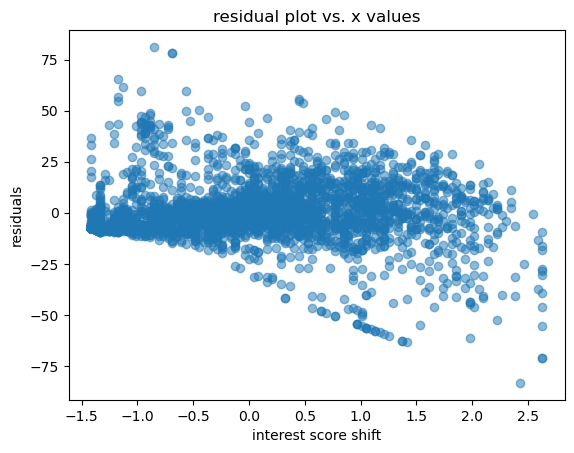

In [69]:
# Plot feature against residuals
plt.scatter(X[["interest_score_shift"]], residuals, alpha=0.5)
plt.xlabel("interest score shift")
plt.ylabel("residuals")
plt.title("residual plot vs. x values")
plt.show()

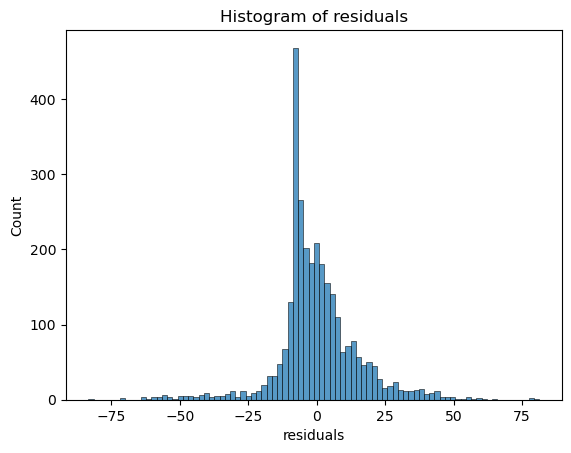

In [70]:
# Plot histogram of residuals
sns.histplot(residuals, kde = False)
plt.xlabel("residuals")
plt.title("Histogram of residuals")
plt.show()

Firstly, this model has a mean squared error of 239.11 and an r^2 value of 0.6075828562117711, which suggests that 60.77% of the variation in the dependent variable - interest score of each health trend search term, can be explained by the variation in the independent variable - interest score shift, or interest score from 20 days ago (short term prediction). Compared with other features as mentioned before, we can see that using interest score from 20 days ago in our linear regression model has the strongest fit on our data. Moreover, the residuals vs. x feature plot spread relatively evenly across 0, with some higher x values having smaller residuals. This plot suggests that generally when interest score shift has decent linearity and homoscedasticity. The histogram of residuals shows a general shape of the normal distribution curve, however, this curve is not centered at 0.

In [109]:
# Line of best fit of both models
intercept_1 = lin_reg.intercept_
coef_1 = lin_reg.coef_
print("Line of best fit of multiple linear regression model:\n",
      f"interest_score = {intercept_1} + {coef_1[0]:.2f}*{features[0]} + {coef_1[1]:.2f}*{features[1]} {coef_1[2]:.2f}*{features[2]} + {coef_1[3]:.2f}*{features[3]}")

intercept_2 = linreg.intercept_
coef_2 = linreg.coef_
print("\nLine of best fit of single linear regression model:\n",
      f"interest_score = {intercept_2} + {coef_2[0]:.2f}*interest_score_shift")

Line of best fit of multiple linear regression model:
 interest_score = 35.502348993288535 + 19.38*interest_score_shift + 3.94*interest_score_diff -1.93*month + 2.94*year

Line of best fit of single linear regression model:
 interest_score = 35.60755321510343 + 6.27*interest_score_shift


Both our multiple and single linear regression models have similar MSE and r^2 values, however, the multiple linear regression has a slightly higher r^2 value, suggesting that it has a stronger fit on our data. When checking for different assumptions, both model did not violate the linearity, homoscedasticity, no autocorrelation. However, the multiple linear regression model shows better normality. Overall, we think that the multiple linear regression model has a better fit on our data.
This suggests that both long-term and short-term features impact the predictions of the interest in each health trend search term. When focusing on each feature specifically, interest score shift, which uses recent interest scores to predict, shows the best fit on our data, which highlights this feature as having a stronger impact on the predictions. On the contrary, recent interest score difference resulted in very low r^2 value and no linearity. This means that beside seasonal popularity atrends tend to have a sustained popularity over long period of time, and don't fluctuate easily, and that sudden spikes or dips in an interest doesn't influence whether or not that trend gains popularity.